In [160]:
from utils.utils import transform_ghg_dataset, create_dataset
from utils.lstm import TimeSeriesLSTM

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

from torchview import draw_graph

torch.manual_seed(42)
torch.cuda.is_available()

True

In [161]:
DEVICE = torch.device("cuda:0")
DATASET = "./dataset/ghg/2050-historical-and-projected-sectoral-emissions-data-November_2023-for-publishing-v01.xlsx"
SYNTH_DATASET = "./dataset/synth/synth_data.csv"
FEATURES = ["Gross - Central"]

In [162]:
df = transform_ghg_dataset(DATASET)
df_synth = pd.read_csv(SYNTH_DATASET).astype("Float32")

print(df.shape)
df.head()

(61, 7)


,Year,Gross - Central,Gross - High,Gross - Low,Net - Target accounting - Central,Net - Target accounting - High,Net - Target accounting - Low
0,1990.0,67903.078125,67903.078125,67903.078125,68753.328125,68753.328125,68753.328125
1,1991.0,68890.218750,68890.218750,68890.218750,69748.593750,69748.593750,69748.593750
2,1992.0,70027.718750,70027.718750,70027.718750,71145.148438,71145.148438,71145.148438
3,1993.0,69923.015625,69923.015625,69923.015625,71114.140625,71114.140625,71114.140625
4,1994.0,71165.445312,71165.445312,71165.445312,72493.937500,72493.937500,72493.937500


In [163]:
# Real dataset
df_tf = df[FEATURES]
df_tf = df_tf.iloc[0:32]

In [164]:
# Synth dataset
syn_1 = 4
syn_2 = 12
syn_3 = 13
syn_4 = 3

df_synth_tf = df_synth[[f"{syn_1}"]].rename(columns={f"{syn_1}": FEATURES[0]})
df_synth_tf_1 = df_synth[[f"{syn_2}"]].rename(columns={f"{syn_2}": FEATURES[0]})
df_synth_tf_2 = df_synth[[f"{syn_3}"]].rename(columns={f"{syn_3}": FEATURES[0]})
df_synth_tf_3 = df_synth[[f"{syn_4}"]].rename(columns={f"{syn_4}": FEATURES[0]})

In [165]:
scaler = MinMaxScaler()

df_tf = scaler.fit_transform(df_tf)

df_synth_tf = scaler.transform(df_synth_tf).astype("float32")
df_synth_tf_1 = scaler.transform(df_synth_tf_1).astype("float32")
df_synth_tf_2 = scaler.transform(df_synth_tf_2).astype("float32")
df_synth_tf_3 = scaler.transform(df_synth_tf_3).astype("float32")

In [166]:
# train test split
train_size = int(len(df_tf) * 0.75)
train, test = df_tf[:train_size], df_tf[train_size:]

print(train.shape, test.shape)

(24, 1) (8, 1)


In [167]:
lookback = 1

# real dataset
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

# synth dataset
X_train_syn, y_train_syn = create_dataset(df_synth_tf, lookback)
X_train_syn_1, y_train_syn_1 = create_dataset(df_synth_tf_1, lookback)
X_train_syn_2, y_train_syn_2 = create_dataset(df_synth_tf_2, lookback)
X_train_syn_3, y_train_syn_3 = create_dataset(df_synth_tf_3, lookback)

In [168]:
dev = "cuda"
if dev == "cuda":
    X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()
    X_train_syn, y_train_syn = X_train_syn.cuda(), y_train_syn.cuda()
    X_train_syn_1, y_train_syn_1 = X_train_syn_1.cuda(), y_train_syn_1.cuda()
    X_train_syn_2, y_train_syn_2 = X_train_syn_2.cuda(), y_train_syn_2.cuda()
    X_train_syn_3, y_train_syn_3 = X_train_syn_3.cuda(), y_train_syn_3.cuda()

In [246]:
SAVE_FILE = "result/loss/2/" + "real_synth_4" + ".png"

real_data_tensor = data.TensorDataset(X_train, y_train)
syn_data_tensor = data.TensorDataset(X_train_syn, y_train_syn)
syn_data_tensor_1 = data.TensorDataset(X_train_syn_1, y_train_syn_1)
syn_data_tensor_2 = data.TensorDataset(X_train_syn_2, y_train_syn_2)
syn_data_tensor_3 = data.TensorDataset(X_train_syn_3, y_train_syn_3)

train_combined = data.ConcatDataset([
    real_data_tensor,
    # syn_data_tensor,
    # syn_data_tensor_1,
    # syn_data_tensor_2,
    syn_data_tensor_3,
    ])

In [247]:
# Training 
model = TimeSeriesLSTM(train.shape[1], 20).cuda()
optimizer = optim.Adam(model.parameters(), 0.001)
criterion = nn.MSELoss()
loader = data.DataLoader(train_combined, shuffle=True, batch_size=32)
epochs = 10000

trains_rmse = []
tests_rmse = []
for epoch in range(1, epochs+1):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % (epochs * 0.01) != 0:
        continue

    model.eval()
    with torch.no_grad():
        y_hat = model(X_train)
        train_rmse = np.sqrt(criterion(y_hat.cpu(), y_train.cpu()))
        trains_rmse.append(train_rmse.item())

        y_pred = model(X_test)
        test_rmse = np.sqrt(criterion(y_pred.cpu(), y_test.cpu()))
        tests_rmse.append(test_rmse.item())

    # print("Epoch %d\ttrain RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

In [248]:
rmse_df = pd.DataFrame({"train": trains_rmse, "test": tests_rmse})

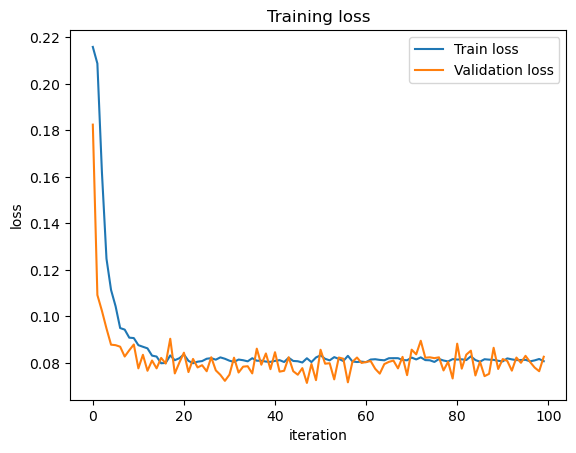

In [249]:
plt.title("Training loss")
plt.plot(rmse_df["train"], label="Train loss")
plt.plot(rmse_df["test"], label="Validation loss")
plt.legend()
plt.ylabel("loss")
plt.xlabel("iteration")
plt.savefig(SAVE_FILE)
plt.show()

In [250]:
# visualize model
# import graphviz
# graphviz.set_jupyter_format('png')

# graph = draw_graph(model, input_size=(32, 1))
# graph.visual_graph

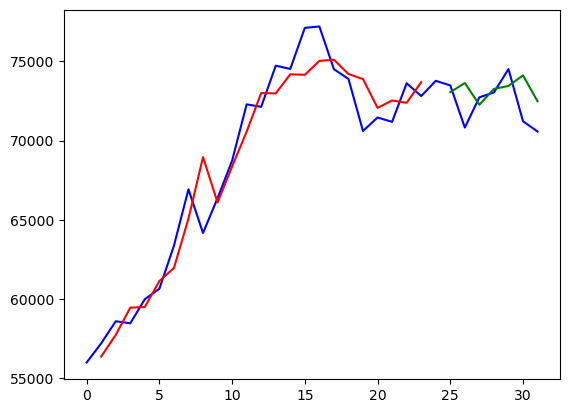

In [251]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_tf) * np.nan
    train_plot[lookback:train_size] = model(X_train).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_tf) * np.nan
    test_plot[train_size+lookback:len(df_tf)] = model(X_test).cpu()[:, -1, :]
    
# plot
plt.plot(scaler.inverse_transform(df_tf), c='b')
plt.plot(scaler.inverse_transform(train_plot), c='r')
plt.plot(scaler.inverse_transform(test_plot), c='g')
plt.show()

In [252]:
# Real Data Test
projection = df[FEATURES]
projection = projection[32:]

projection_train = scaler.fit_transform(projection)
X_projection, y_projection = create_dataset(projection_train, lookback)
X_projection, y_projection = X_projection.cuda(), y_projection.cuda()

with torch.no_grad():
    projection_plot = np.ones_like(projection) * np.nan
    projection_pred = model(X_projection).cpu()[:, -1, :]
    projection_plot[lookback:] = projection_pred
    real_rmse = np.sqrt(criterion(projection_pred, torch.squeeze(y_projection).reshape(len(y_projection), 1).cpu()))

projection_train_plt = scaler.inverse_transform(projection_train)
projection_plot_plt = scaler.inverse_transform(projection_plot)

In [253]:
temp = torch.squeeze(y_projection).reshape(len(y_projection), 1).cpu()
temp = scaler.inverse_transform(temp)
temp_hat = scaler.inverse_transform(projection_pred)

real_rmse_scaler = np.sqrt(criterion(torch.tensor(temp_hat), torch.tensor(temp)))

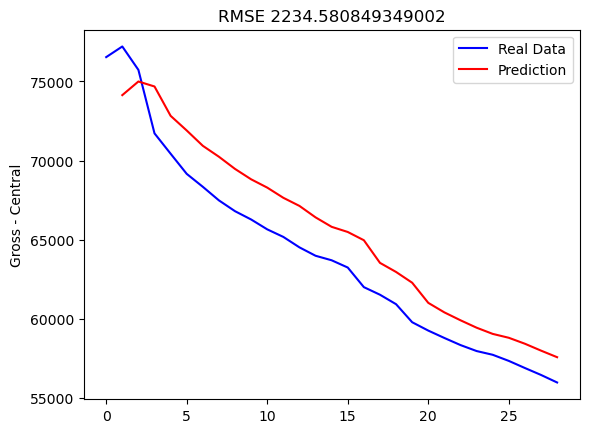

In [254]:
plt.title(f"RMSE {real_rmse_scaler}")
plt.plot(projection_train_plt, c='b', label="Real Data")
plt.plot(projection_plot_plt, c='r', label="Prediction")
plt.ylabel("Gross - Central")
plt.legend()
# plt.savefig(SAVE_FILE)
plt.show()

In [255]:
pred = np.delete(projection_train_plt, 0, 0)
true = np.delete(projection_plot_plt, 0, 0)
print(pred.shape, true.shape)

(28, 1) (28, 1)


In [256]:
print(mean_absolute_percentage_error(true, pred) * 100)

3.2632015645504
